# Техническая часть

In [ ]:
!git clone https://github.com/DanilDmitriev1999/competitions

fatal: destination path 'competitions' already exists and is not an empty directory.


In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import math
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, Dataset, RandomSampler, TensorDataset

from transformers import DistilBertModel, DistilBertTokenizer
from transformers import BertModel, BertTokenizer

np.random.seed(42)
torch.manual_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Загрузка данных и EDA

In [ ]:
train = pd.read_csv("competitions/final_project/train.csv", sep='	', index_col=0)
test = pd.read_csv("competitions/final_project/test.csv", sep='	', index_col=0)

In [ ]:
train.head()

,text,class
11028,Издание Arabian Business Magazine опубликовало...,true
11570,Физик Эдуард Хейндль из Фуртвангенского универ...,true
10000,Итальянский специалист Фабио Капелло останется...,true
4668,В белорусских кинотеатрах запись инаугурации П...,fake
11358,Премьер-министр Украины Юлия Тимошенко 8 февра...,true


In [ ]:
train['text'].isnull().sum()

117

In [ ]:
train = train.dropna()
train['text'].isnull().sum()

0

In [ ]:
def tru_fake(b):
    if b == 'true':
        return 1
    elif b == 'fake':
        return 0

train['class'] = train.apply(lambda r: tru_fake(r['class']), axis=1)
train.head(2)

,text,class
11028,Издание Arabian Business Magazine опубликовало...,1
11570,Физик Эдуард Хейндль из Фуртвангенского универ...,1


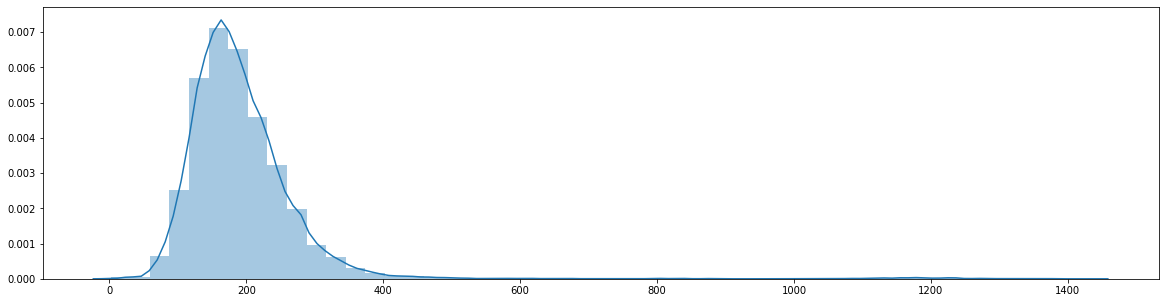

In [ ]:
len_review = [len(i.split(' ')) for i in train['text'].values]

plt.figure(figsize=(20, 5))
sns.distplot(len_review)

In [ ]:
train['class'].value_counts()

1    15919
0     3964
Name: class, dtype: int64

In [ ]:
text_train, text_val, label_train, label_val = train_test_split(train['text'], train['class'].values,
                                                    test_size=0.01, stratify=train['class'].values,
                                                     random_state=40)

# Строим модель

In [ ]:
class CreateDataset(Dataset):

  def __init__(self, sentence, targets, tokenizer, max_len):
    self.sentence = sentence
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.sentence)
  
  def __getitem__(self, item):
    sentence = str(self.sentence[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      sentence,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True
    )

    return {
      'sentence_text': sentence,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }


def create_data_loader(dt, tokenizer, max_len, batch_size):
  ds = CreateDataset(
    sentence=dt['sentence'],
    targets=dt['label'],
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size
  )


# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')
tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')

In [ ]:
train_dataEng = {'sentence':[i for i in text_train],
              'label':[i for i in label_train]}
val_dataEng = {'sentence':[i for i in text_val],
              'label':[i for i in label_val]}

BATCH_SIZE = 8
MAX_LEN = 400

train_data_loader_eng = create_data_loader(train_dataEng, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader_eng = create_data_loader(val_dataEng, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
class SentimentClassifier(nn.Module):
  def __init__(self, hidden_dim=256, bidirectional=True, num_layers=1):
    super(SentimentClassifier, self).__init__()
    # self.bert = DistilBertModel.from_pretrained('distilbert-base-multilingual-cased')
    self.bert = BertModel.from_pretrained('DeepPavlov/rubert-base-cased')


    self.rnn = nn.GRU(768, hidden_dim, bidirectional=bidirectional,
                      num_layers=num_layers, batch_first=True,
                      dropout = 0 if num_layers < 2 else 0.1)
    
    self.drop = nn.Dropout(p=0.1)
    self.linear = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, 1)
  
  def forward(self, input_ids, attention_mask):
    bert_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )[0]

    output = self.drop(bert_output)

    _, hidden = self.rnn(output)

    output = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
    output = self.linear(output)

    return output

In [ ]:
def do_epoch(model, criterion, data, optimizer=None, name=None):
    epoch_loss = 0
    epoch_f1 = 0

    
    is_train = not optimizer is None
    name = name or ''
    model.train(is_train)
    
    batches_count = len(data)
    
    with torch.autograd.set_grad_enabled(is_train):
        with tqdm(total=batches_count) as progress_bar:
            for batch in data:
                text = batch["input_ids"].to(device)
                targets = batch["targets"].to(device)
                mask = batch["attention_mask"].to(device)

                torch.cuda.empty_cache()
                outputs = model(
                    input_ids=text,
                    attention_mask=mask
                                ).squeeze(1)

                preds = torch.round(torch.sigmoid(outputs))

                loss = criterion(outputs.float(), targets.float())
                
                f1 = f1_score(targets.cpu().detach().numpy(), preds.cpu().detach().numpy())


                epoch_loss += loss.item()
                epoch_f1 += f1

                if optimizer:
                    loss.backward()
                    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    optimizer.step()
                    optimizer.zero_grad()

                progress_bar.update()
                progress_bar.set_description('{:>5s} Average Loss = {:.5f}, F1-score = {:.3%}'.format(
                    name, loss , f1))

            progress_bar.set_description('{:>5s} Average Loss = {:.5f}, F1-score = {:.3%}'.format(
                name, epoch_loss / batches_count, epoch_f1 / batches_count))

    return epoch_loss / batches_count


def fit(model, criterion, optimizer, train_data, epochs_count=1,
        val_data=None):
    for epoch in range(epochs_count):
        name_prefix = '[{} / {}] '.format(epoch + 1, epochs_count)
        train_loss = do_epoch(model, criterion, train_data, optimizer, name_prefix + 'Train:')
        
        if not val_data is None:
            val_loss = do_epoch(model, criterion, val_data, None, name_prefix + '  Val:')

In [ ]:
hidden_dim = 256
model = SentimentClassifier(hidden_dim)
model = model.to(device)

EPOCHS = 3

optimizer = optim.Adam(model.parameters(), lr=5e-5)
criterion = nn.BCEWithLogitsLoss().to(device)
fit(model, criterion, optimizer, train_data=train_data_loader_eng,
    epochs_count=EPOCHS, val_data=val_data_loader_eng)

[1 / 3] Train: Average Loss = 0.09540, F1-score = 98.445%: 100%|██████████| 2461/2461 [1:13:07<00:00,  1.78s/it]
[1 / 3]   Val: Average Loss = 0.10346, F1-score = 98.142%: 100%|██████████| 25/25 [00:12<00:00,  2.03it/s]
[2 / 3] Train: Average Loss = 0.12147, F1-score = 97.133%: 100%|██████████| 2461/2461 [1:13:10<00:00,  1.78s/it]
[2 / 3]   Val: Average Loss = 0.28915, F1-score = 95.798%: 100%|██████████| 25/25 [00:12<00:00,  2.04it/s]
[3 / 3] Train: Average Loss = 0.18347, F1-score = 93.333%:  54%|█████▎    | 1322/2461 [39:22<33:56,  1.79s/it]

In [ ]:
def predict_bert(text, model):
    encoded_review = tokenizer.encode_plus(
        text,
        max_length=MAX_LEN,
        add_special_tokens=True,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
        )
    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)

    output = model(input_ids, attention_mask).squeeze(1)
    preds = torch.round(torch.sigmoid(output))
    return preds.cpu().detach().numpy()[0]

In [ ]:
a = predict_bert(ts[0], model)

In [ ]:
a

1.0

# сабмит теста

In [ ]:
test.head()

,text
9217,Кандидат на пост президента Украины Олег Царев...
22179,"Болельщики бразильского клуба ""Фламенго"" за дв..."
15357,Префект Северного административного округа Мос...
2930,Президентский Ельцин-центр пополнил свою экспо...
4834,Задержанного полицией безопасности Эстонии 20-...


In [ ]:
test['text'].isnull().sum()

22

In [ ]:
test = test.fillna('-')

In [ ]:
ts = test['text'].values

In [ ]:
result = [predict_bert(i, model) for i in ts]

In [ ]:
test.shape, len(result)

((5046, 1), 5046)

In [ ]:
test['class'] = result
test.head()

,text,class
9217,Кандидат на пост президента Украины Олег Царев...,1.0
22179,"Болельщики бразильского клуба ""Фламенго"" за дв...",1.0
15357,Префект Северного административного округа Мос...,1.0
2930,Президентский Ельцин-центр пополнил свою экспо...,0.0
4834,Задержанного полицией безопасности Эстонии 20-...,0.0


In [ ]:
test['class'].value_counts()

1.0    3980
0.0    1066
Name: class, dtype: int64



```
1.0    3990
0.0    1056
Name: class, dtype: int64
```



In [ ]:
def int2class(b):
    if b == 1:
        return 'true'
    elif b == 0:
        return 'fake'

test['class'] = test.apply(lambda r: int2class(r['class']), axis=1)
test.head(2)

,text,class
9217,Кандидат на пост президента Украины Олег Царев...,true
22179,"Болельщики бразильского клуба ""Фламенго"" за дв...",true


In [ ]:
test.to_csv('test.csv', sep='\t', index=False)